# Prerequisite: start the cluster

To use this notebook, we need an A100 VM and a TPU v5litepod-8 VM.
Both VMs should be reachable via IP address to each other.
This notebook is run on the A100 VM, which is also the ray head node.

Starting the head node:

```sh
ray start --head --port=6379
```

Joining the ray cluster from the TPU VM:

```sh
ray start --address=$GPU_IP:6379
```

In [ ]:
import ray

ray.init()

2025-04-30 08:37:37,337	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.128.0.32:6379...
2025-04-30 08:37:37,351	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.14
Ray version:,2.44.1
Dashboard:,http://127.0.0.1:8265


(TpuResNetWorker pid=146446, ip=10.138.0.2) WARNING:root:libtpu.so and TPU device found. Setting PJRT_DEVICE=TPU.


(pid=, ip=10.138.0.2) Log file created at: 2025/04/30 01:39:18
(pid=, ip=10.138.0.2) Running on machine: t1v-n-8ed780ed-w-0
(pid=, ip=10.138.0.2) Binary: Built on Jan 24 2025 17:49:30 (1737769770)
(pid=, ip=10.138.0.2) Binary: Built at cloud-tpus-runtime-release-tool@lmbco37.prod.google.com:/google/src/cloud/buildrabbit-username/buildrabbit-client/g3     
(pid=, ip=10.138.0.2) Binary: Built for gcc-4.X.Y-crosstool-v18-llvm-grtev4-k8.k8
(pid=, ip=10.138.0.2) Log line format: [IWEF]mmdd hh:mm:ss.uuuuuu threadid file:line] msg
(pid=, ip=10.138.0.2) I0430 01:39:18.536825  146446 b295d63588a.cc:733] Linux version 6.5.0-1013-gcp (buildd@lcy02-amd64-064) (x86_64-linux-gnu-gcc-12 (Ubuntu 12.3.0-1ubuntu1~22.04) 12.3.0, GNU ld (GNU Binutils for Ubuntu) 2.38) #13~22.04.1-Ubuntu SMP Wed Jan 24 23:39:40 UTC 2024
(pid=, ip=10.138.0.2) I0430 01:39:18.546313  146446 b295d63588a.cc:815] Process id 146446
(pid=, ip=10.138.0.2) I0430 01:39:18.546328  146446 b295d63588a.cc:820] Current working directory /

0it [00:00, ?it/s]ker pid=146446, ip=10.138.0.2) 
8it [00:00, 61.04it/s]pid=146446, ip=10.138.0.2) 


(TpuResNetWorker pid=146446, ip=10.138.0.2) Concatenating datasets...
(TpuResNetWorker pid=146446, ip=10.138.0.2) Collecting label indices...


30it [00:00, 141.48it/s]d=146446, ip=10.138.0.2) 
60it [00:00, 207.69it/s]d=146446, ip=10.138.0.2) 
82it [00:00, 180.10it/s]d=146446, ip=10.138.0.2) 
110it [00:00, 209.46it/s]=146446, ip=10.138.0.2) 
141it [00:00, 238.45it/s]=146446, ip=10.138.0.2) 
166it [00:00, 231.21it/s]=146446, ip=10.138.0.2) 
197it [00:00, 252.86it/s]=146446, ip=10.138.0.2) 
227it [00:01, 265.08it/s]=146446, ip=10.138.0.2) 
257it [00:01, 275.20it/s]=146446, ip=10.138.0.2) 
286it [00:01, 277.31it/s]=146446, ip=10.138.0.2) 
317it [00:01, 285.29it/s]=146446, ip=10.138.0.2) 
346it [00:01, 265.74it/s]=146446, ip=10.138.0.2) 
377it [00:01, 276.14it/s]=146446, ip=10.138.0.2) 
408it [00:01, 284.05it/s]=146446, ip=10.138.0.2) 
437it [00:01, 275.24it/s]=146446, ip=10.138.0.2) 
468it [00:01, 283.11it/s]=146446, ip=10.138.0.2) 
498it [00:01, 287.69it/s]=146446, ip=10.138.0.2) 
528it [00:02, 290.36it/s]=146446, ip=10.138.0.2) 
558it [00:02, 293.17it/s]=146446, ip=10.138.0.2) 
588it [00:02, 294.32it/s]=146446, ip=10.138.0.2) 


(TpuResNetWorker pid=146446, ip=10.138.0.2) Found 10177 unique celebrity IDs
(TpuResNetWorker pid=146446, ip=10.138.0.2) Creating train/test splits...
(TpuResNetWorker pid=146446, ip=10.138.0.2) Train indices: 159267, Test indices: 43288
(TpuResNetWorker pid=146446, ip=10.138.0.2) Creating train dataset
(TpuResNetWorker pid=146446, ip=10.138.0.2) Creating test dataset
(TpuResNetWorker pid=146446, ip=10.138.0.2) Saving train dataset to disk...
(TpuResNetWorker pid=146446, ip=10.138.0.2) Number of classes: 10177
(TpuResNetWorker pid=146446, ip=10.138.0.2) Train set size: 159267
(TpuResNetWorker pid=146446, ip=10.138.0.2) Test set size: 43288


  0%|          | 0/43288 [00:00<?, ?it/s]38.0.2) 


(TpuResNetWorker pid=146446, ip=10.138.0.2) Saving test dataset to disk...


100%|██████████| 43288/43288 [04:45<00:00, 151.55it/s]


(TpuResNetWorker pid=146446, ip=10.138.0.2) Datasets cached successfully.
(TpuResNetWorker pid=146446, ip=10.138.0.2) Using cached datasets.
(TpuResNetWorker pid=146446, ip=10.138.0.2) Number of classes: 10177
(TpuResNetWorker pid=146446, ip=10.138.0.2) Train set size: 159267
(TpuResNetWorker pid=146446, ip=10.138.0.2) Test set size: 43288


In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader, default_collate
from torchvision import datasets, models, tv_tensors

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

import random

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## Look at our training data

In [3]:
from datasets import load_dataset

def load_raw_dataset(split):
  dataset = load_dataset("flwrlabs/celeba", split=split, trust_remote_code=True, cache_dir='cache')
  return dataset.with_format("torch")

train = load_raw_dataset("train")
test = load_raw_dataset("test")
valid = load_raw_dataset("valid")

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

In [4]:
train_set = train.unique('celeb_id') # type: ignore
test_set = test.unique('celeb_id') # type: ignore
valid_set = valid.unique('celeb_id') # type: ignore
print(f"Train set: {len(train_set)}")
print(f"Test set: {len(test_set)}")
print(f"Valid set: {len(valid_set)}")
print(f"Total unique IDs: {len(set(train_set) | set(test_set) | set(valid_set))}")

Train set: 8192
Test set: 1000
Valid set: 985
Total unique IDs: 10177


Problem: there is no label overlap between train/test/valid sets.

We can't use the validation set to validate accuracy because it contains
completely unseen labels.

For the purpose of this specific convergence test, we'll do our own split
such that the same labels show up in both train and test sets.

In [5]:
from data_util import download_dataset_custom_split_cached

train_dataset, test_dataset, NUM_CLASSES = download_dataset_custom_split_cached()

Using cached datasets.


Number of classes: 10177
Train set size: 159267
Test set size: 43288


In [6]:
from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=8, shuffle=False)  # type: ignore

# Enumerate train loader to find number of unique labels
train_unique_labels = set()
for batch in tqdm(train_loader):
    labels = batch['label']
    train_unique_labels.update(set(labels.flatten().numpy().tolist()))
print(f"Number of unique labels in train loader: {len(train_unique_labels)}")
# Enumerate test loader to find number of unique labels
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=8, shuffle=False)  # type: ignore
test_unique_labels = set()
for batch in tqdm(test_loader):
    labels = batch['label']
    test_unique_labels.update(set(labels.flatten().numpy().tolist()))
print(f"Number of unique labels in test loader: {len(test_unique_labels)}")

100%|██████████| 2489/2489 [00:56<00:00, 44.04it/s]


Number of unique labels in train loader: 10133


100%|██████████| 677/677 [00:10<00:00, 65.36it/s]

Number of unique labels in test loader: 10133


In [7]:
NUM_CLASSES = len(train_unique_labels)
print(f"Number of classes: {NUM_CLASSES}")
assert train_unique_labels == test_unique_labels

Number of classes: 10133


In [8]:
sorted(list(train_unique_labels))[-10:], sorted(list(test_unique_labels))[-10:]

([10167, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176],
 [10167, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176])

In [9]:
from actors import get_gpu_actor

gpu_actor = get_gpu_actor()
print(ray.get(gpu_actor.print_model_architecture.remote()))
print(ray.get(gpu_actor.get_cwd.remote()))

GPU Actor (PID: 2084896) using cuda (NVIDIA A100-SXM4-80GB)
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

## Convergence test

Now let's run a proper training run with:

- Learning rate: `1e-4` (smaller than the existing `1e-3`)
- Batch size: 512 (unchanged)
- Training set: `flwrlabs/celeba/train`
- Validation set (used to compute validation accuracy): `flwrlabs/celeba/valid`
- Measure:
  - val-loss
  - val-top1-acc
- Final evaluation: `flwrlabs/celeba/test`

If TPU is materially worse on val-top1-acc with same LR/batchsize, that's a
material datapoint and we probably want to bring it back to the TPU team to see
if that's also expected behavior.

In [10]:
from tqdm import tqdm
from actors import get_tpu_actor, reset_all_actors, ActorResetter

actor_resetter = ActorResetter(gpu_actor=gpu_actor, num_classes=NUM_CLASSES)
gpu_actor, tpu_actor = reset_all_actors(gpu_actor, tpu_actor=None, actor_resetter=actor_resetter)
ray.get(tpu_actor.set_matmul_precision.remote('default'))
ray.get(gpu_actor.init_optimizer.remote(1e-4))
ray.get(tpu_actor.init_optimizer.remote(1e-4))

BATCH_SIZE = 512
training_split = 'custom'

gpu_losses = []
tpu_losses = []
gpu_validation_metrics = []
tpu_validation_metrics = []
for epoch in range(40):
  gpu_stream = gpu_actor.run_training_epoch.remote(batch_size=BATCH_SIZE, training_split=training_split, shuffle=True, run_validation=True, dataloader_seed=epoch)
  tpu_stream = tpu_actor.run_training_epoch.remote(batch_size=BATCH_SIZE, training_split=training_split, shuffle=True, run_validation=True, dataloader_seed=epoch)
  progress = tqdm(zip(gpu_stream, tpu_stream, strict=True))
  gpu_loss = None
  tpu_loss = None
  for gpu_stuff, tpu_stuff in progress:
    gpu_stuff = ray.get(gpu_stuff)
    tpu_stuff = ray.get(tpu_stuff)
    if isinstance(gpu_stuff, tuple) and isinstance(tpu_stuff, tuple):
      i, gpu_loss, gpu_data_hash = gpu_stuff
      j, tpu_loss, tpu_data_hash = tpu_stuff
      if i != j:
        raise ValueError("Iteration numbers do not match between GPU and TPU actors!")
      if gpu_data_hash != tpu_data_hash:
        raise ValueError("Data hashes do not match between GPU and TPU actors!")
      gpu_losses.append(gpu_loss)
      tpu_losses.append(tpu_loss)
      progress.set_postfix_str(f"Epoch {epoch} Iter {i} | GPU Loss: {gpu_loss:.6f} | TPU Loss: {tpu_loss:.6f}")
    elif isinstance(gpu_stuff, dict) and isinstance(tpu_stuff, dict):
      gpu_validation_metrics.append(gpu_stuff)
      tpu_validation_metrics.append(tpu_stuff)
      progress.set_postfix_str(f"Epoch {epoch} | GPU Loss: {gpu_loss:.6f} | TPU Loss: {tpu_loss:.6f} | GPU Validation: {gpu_stuff} | TPU Validation: {tpu_stuff}")
    else:
      raise ValueError(f"Unexpected data types from GPU and TPU actors! {type(gpu_stuff)}, {type(tpu_stuff)}")


GPU Actor (PID: 2085019) using cuda (NVIDIA A100-SXM4-80GB)
TPU Actor (PID: 146446) using xla:0 (v5litepod-8)
✅ GPU and TPU models have identical state dicts


0it [34:24, ?it/s]


RayTaskError(AttributeError): [36mray::GpuResNetWorker.run_training_epoch()[39m (pid=2085019, ip=10.128.0.32, actor_id=aa2128eb999877608631692c26000000, repr=<actors.GpuResNetWorker object at 0x7fd931625930>)
    for i, batch in enumerate(train_loader):
  File "/home/yifeit_google_com/resnet18/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 491, in __iter__
    return self._get_iterator()
  File "/home/yifeit_google_com/resnet18/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 422, in _get_iterator
    return _MultiProcessingDataLoaderIter(self)
  File "/home/yifeit_google_com/resnet18/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1146, in __init__
    w.start()
  File "/home/yifeit_google_com/.local/share/uv/python/cpython-3.10.14-linux-x86_64-gnu/lib/python3.10/multiprocessing/process.py", line 121, in start
    self._popen = self._Popen(self)
  File "/home/yifeit_google_com/.local/share/uv/python/cpython-3.10.14-linux-x86_64-gnu/lib/python3.10/multiprocessing/context.py", line 288, in _Popen
    return Popen(process_obj)
  File "/home/yifeit_google_com/.local/share/uv/python/cpython-3.10.14-linux-x86_64-gnu/lib/python3.10/multiprocessing/popen_spawn_posix.py", line 32, in __init__
    super().__init__(process_obj)
  File "/home/yifeit_google_com/.local/share/uv/python/cpython-3.10.14-linux-x86_64-gnu/lib/python3.10/multiprocessing/popen_fork.py", line 19, in __init__
    self._launch(process_obj)
  File "/home/yifeit_google_com/.local/share/uv/python/cpython-3.10.14-linux-x86_64-gnu/lib/python3.10/multiprocessing/popen_spawn_posix.py", line 47, in _launch
    reduction.dump(process_obj, fp)
  File "/home/yifeit_google_com/.local/share/uv/python/cpython-3.10.14-linux-x86_64-gnu/lib/python3.10/multiprocessing/reduction.py", line 60, in dump
    ForkingPickler(file, protocol).dump(obj)
AttributeError: Can't pickle local object 'download_dataset_custom_split_cached.<locals>.CachedDataset'

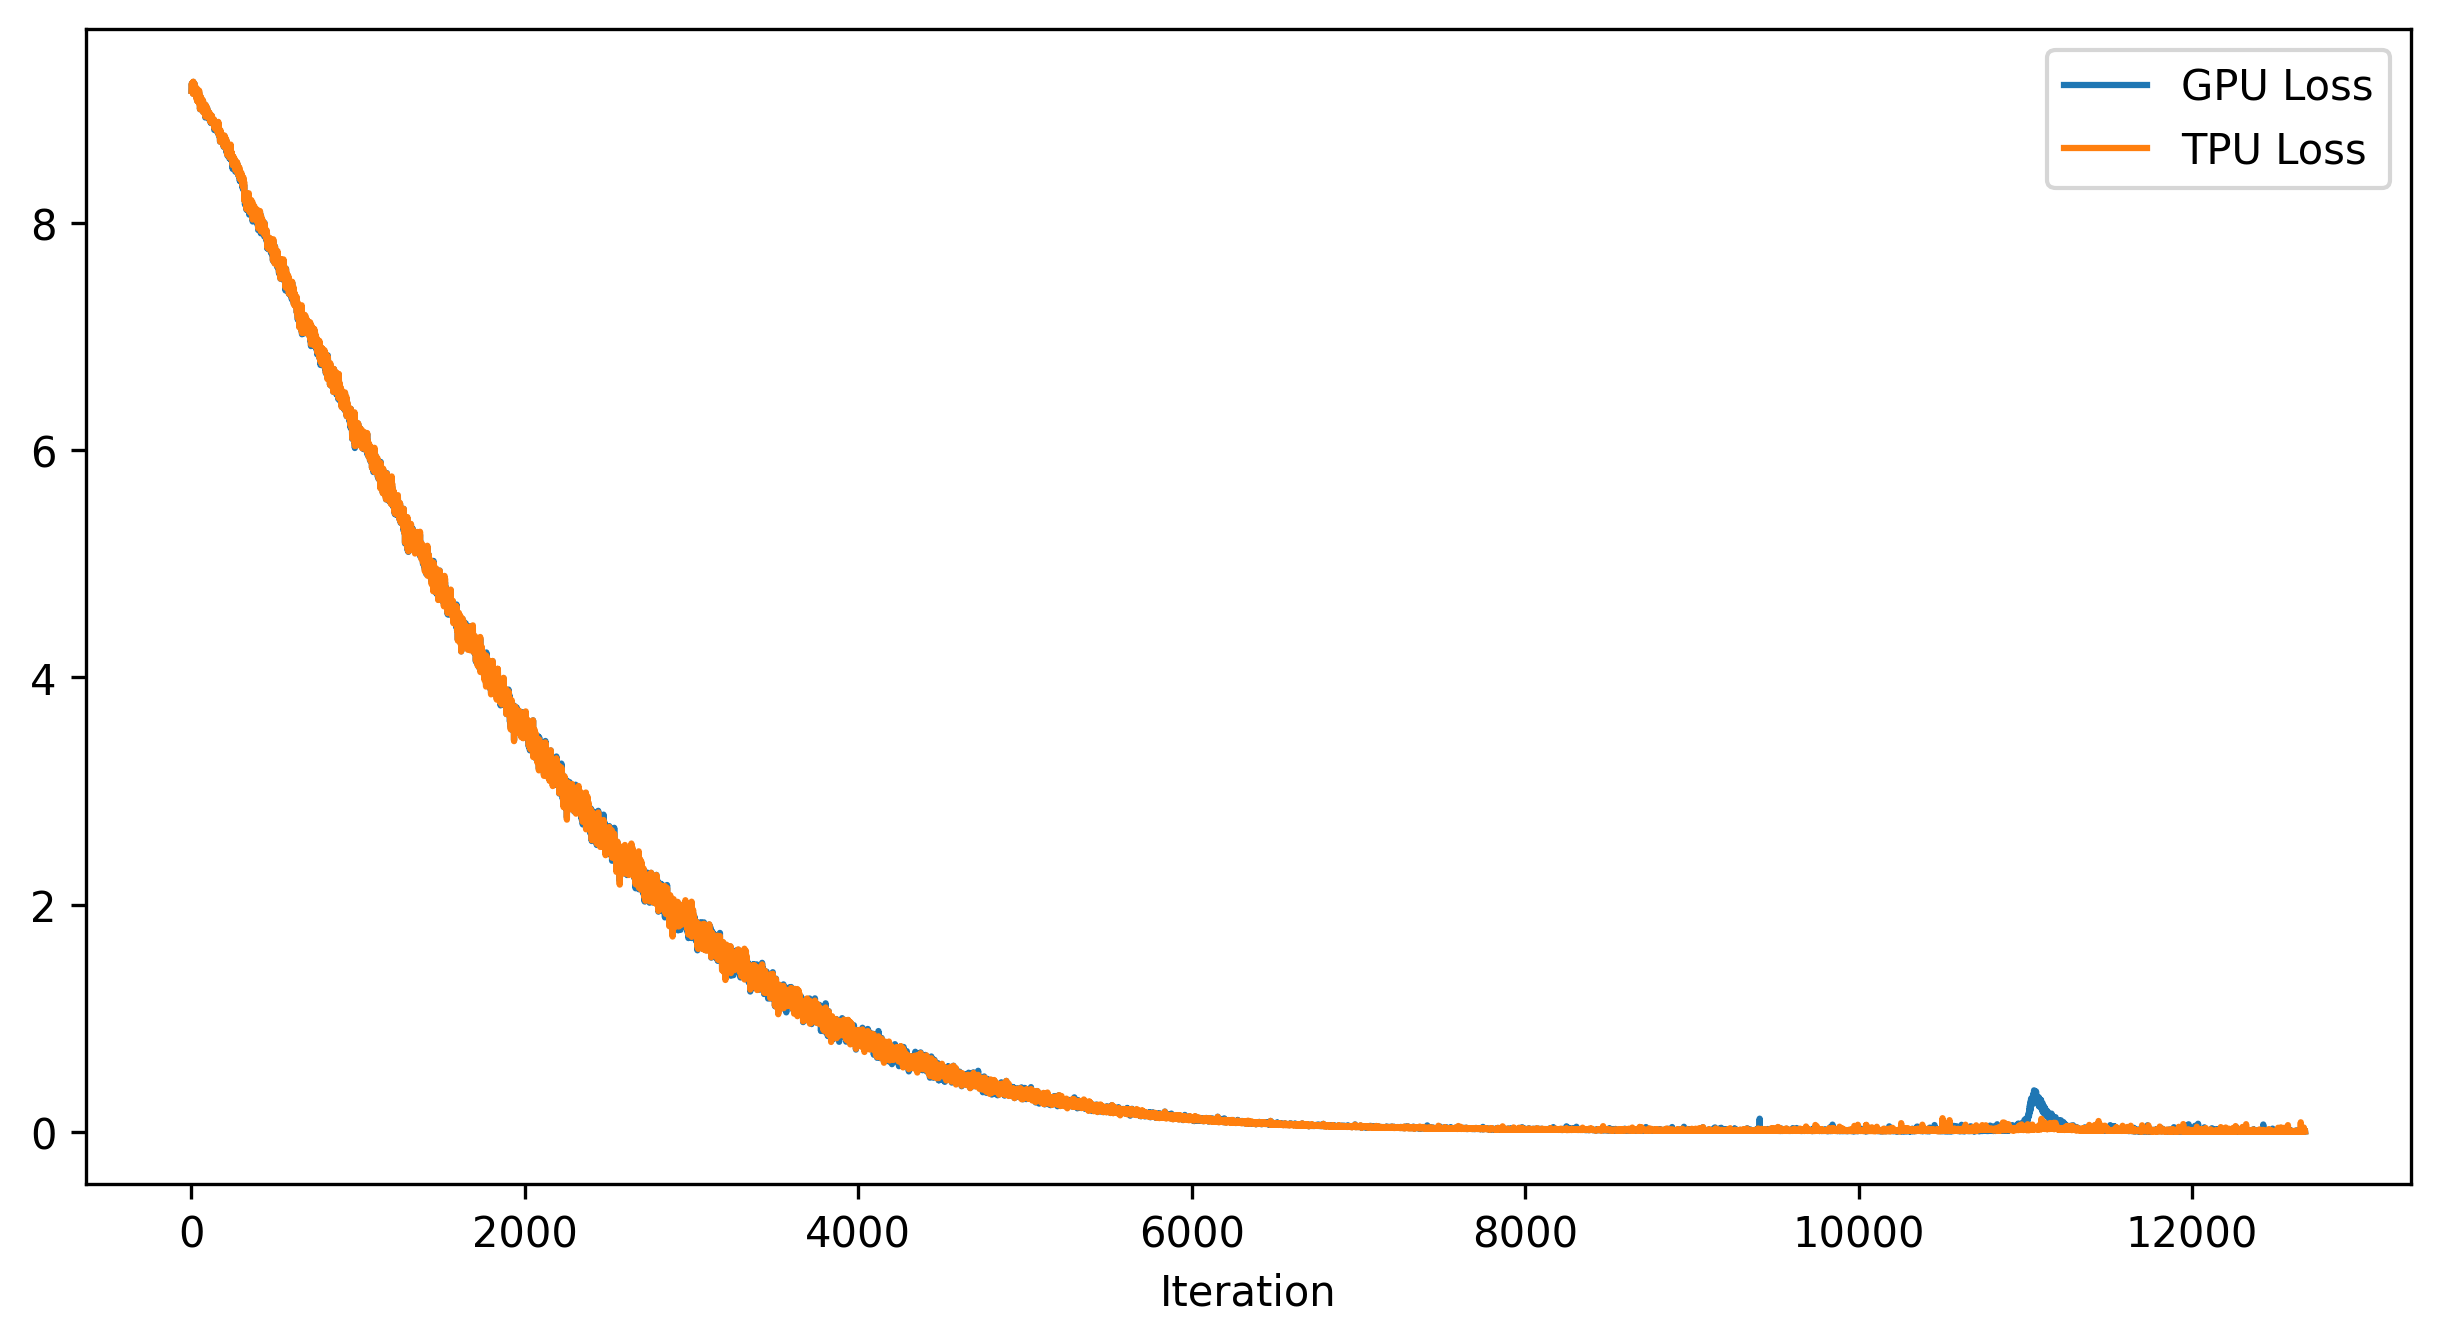

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(gpu_losses, label='GPU Loss')
plt.plot(tpu_losses, label='TPU Loss')
plt.xlabel('Iteration') 
plt.legend()
plt.show()

In [ ]:
import os
import json

# Save the gpu and tpu losses to `outputs/` in JSON format.
os.makedirs("outputs/convergence/lr-1e-4", exist_ok=True)

with open("outputs/convergence/lr-1e-4/gpu_losses.json", "w") as f:
  json.dump(gpu_losses, f)

with open("outputs/convergence/lr-1e-4/tpu_losses.json", "w") as f:
  json.dump(tpu_losses, f)

with open("outputs/convergence/lr-1e-4/gpu_validation_metrics.json", "w") as f:
  json.dump(gpu_validation_metrics, f)

with open("outputs/convergence/lr-1e-4/tpu_validation_metrics.json", "w") as f:
  json.dump(tpu_validation_metrics, f)

### Appendix: test LR=1e-3

See if this will cause loss spikes.

In [ ]:
from tqdm import tqdm
actor_resetter = ActorResetter(gpu_actor=gpu_actor, num_classes=NUM_CLASSES)
gpu_actor, tpu_actor = reset_all_actors(gpu_actor, tpu_actor=None, actor_resetter=actor_resetter)
ray.get(tpu_actor.set_matmul_precision.remote('default'))
ray.get(gpu_actor.init_optimizer.remote(1e-3))
ray.get(tpu_actor.init_optimizer.remote(1e-3))

BATCH_SIZE = 512
training_split = 'custom'

gpu_losses = []
tpu_losses = []
gpu_validation_metrics = []
tpu_validation_metrics = []
for epoch in range(40):
  gpu_stream = gpu_actor.run_training_epoch.remote(batch_size=BATCH_SIZE, training_split=training_split, shuffle=True, run_validation=True, dataloader_seed=epoch)
  tpu_stream = tpu_actor.run_training_epoch.remote(batch_size=BATCH_SIZE, training_split=training_split, shuffle=True, run_validation=True, dataloader_seed=epoch)
  progress = tqdm(zip(gpu_stream, tpu_stream, strict=True))
  gpu_loss = None
  tpu_loss = None
  for gpu_stuff, tpu_stuff in progress:
    gpu_stuff = ray.get(gpu_stuff)
    tpu_stuff = ray.get(tpu_stuff)
    if isinstance(gpu_stuff, tuple) and isinstance(tpu_stuff, tuple):
      i, gpu_loss, gpu_data_hash = gpu_stuff
      j, tpu_loss, tpu_data_hash = tpu_stuff
      if i != j:
        raise ValueError("Iteration numbers do not match between GPU and TPU actors!")
      if gpu_data_hash != tpu_data_hash:
        raise ValueError("Data hashes do not match between GPU and TPU actors!")
      gpu_losses.append(gpu_loss)
      tpu_losses.append(tpu_loss)
      progress.set_postfix_str(f"Epoch {epoch} Iter {i} | GPU Loss: {gpu_loss:.6f} | TPU Loss: {tpu_loss:.6f}")
    elif isinstance(gpu_stuff, dict) and isinstance(tpu_stuff, dict):
      gpu_validation_metrics.append(gpu_stuff)
      tpu_validation_metrics.append(tpu_stuff)
      progress.set_postfix_str(f"Epoch {epoch} | GPU Loss: {gpu_loss:.6f} | TPU Loss: {tpu_loss:.6f} | GPU Validation: {gpu_stuff} | TPU Validation: {tpu_stuff}")
    else:
      raise ValueError(f"Unexpected data types from GPU and TPU actors! {type(gpu_stuff)}, {type(tpu_stuff)}")


GPU Actor (PID: 3400624) using cuda (NVIDIA A100-SXM4-80GB)
TPU Actor (PID: 1237365) using xla:0 (v5litepod-8)
✅ GPU and TPU models have identical state dicts


318it [08:53,  1.68s/it, Epoch 0 | GPU Loss: 8.948339 | TPU Loss: 8.800580 | GPU Validation: {'avg_valid_loss': 9.057168300335224, 'top1_accuracy': 0.0, 'top5_accuracy': 0.0} | TPU Validation: {'avg_valid_loss': 9.17905452923897, 'top1_accuracy': 0.00010066945185483464, 'top5_accuracy': 0.0002516736296370866}]
318it [08:41,  1.64s/it, Epoch 1 | GPU Loss: 8.285970 | TPU Loss: 7.300141 | GPU Validation: {'avg_valid_loss': 9.798181142562475, 'top1_accuracy': 0.0, 'top5_accuracy': 0.0002013389037096693} | TPU Validation: {'avg_valid_loss': 11.10123959565774, 'top1_accuracy': 0.00015100417778225197, 'top5_accuracy': 0.0005536819852015905}]
318it [08:50,  1.67s/it, Epoch 2 | GPU Loss: 7.101722 | TPU Loss: 5.402316 | GPU Validation: {'avg_valid_loss': 11.930481837346004, 'top1_accuracy': 0.00010066945185483464, 'top5_accuracy': 0.0002516736296370866} | TPU Validation: {'avg_valid_loss': 14.824173218164688, 'top1_accuracy': 0.0002013389037096693, 'top5_accuracy': 0.0010570292444757638}]
318it 

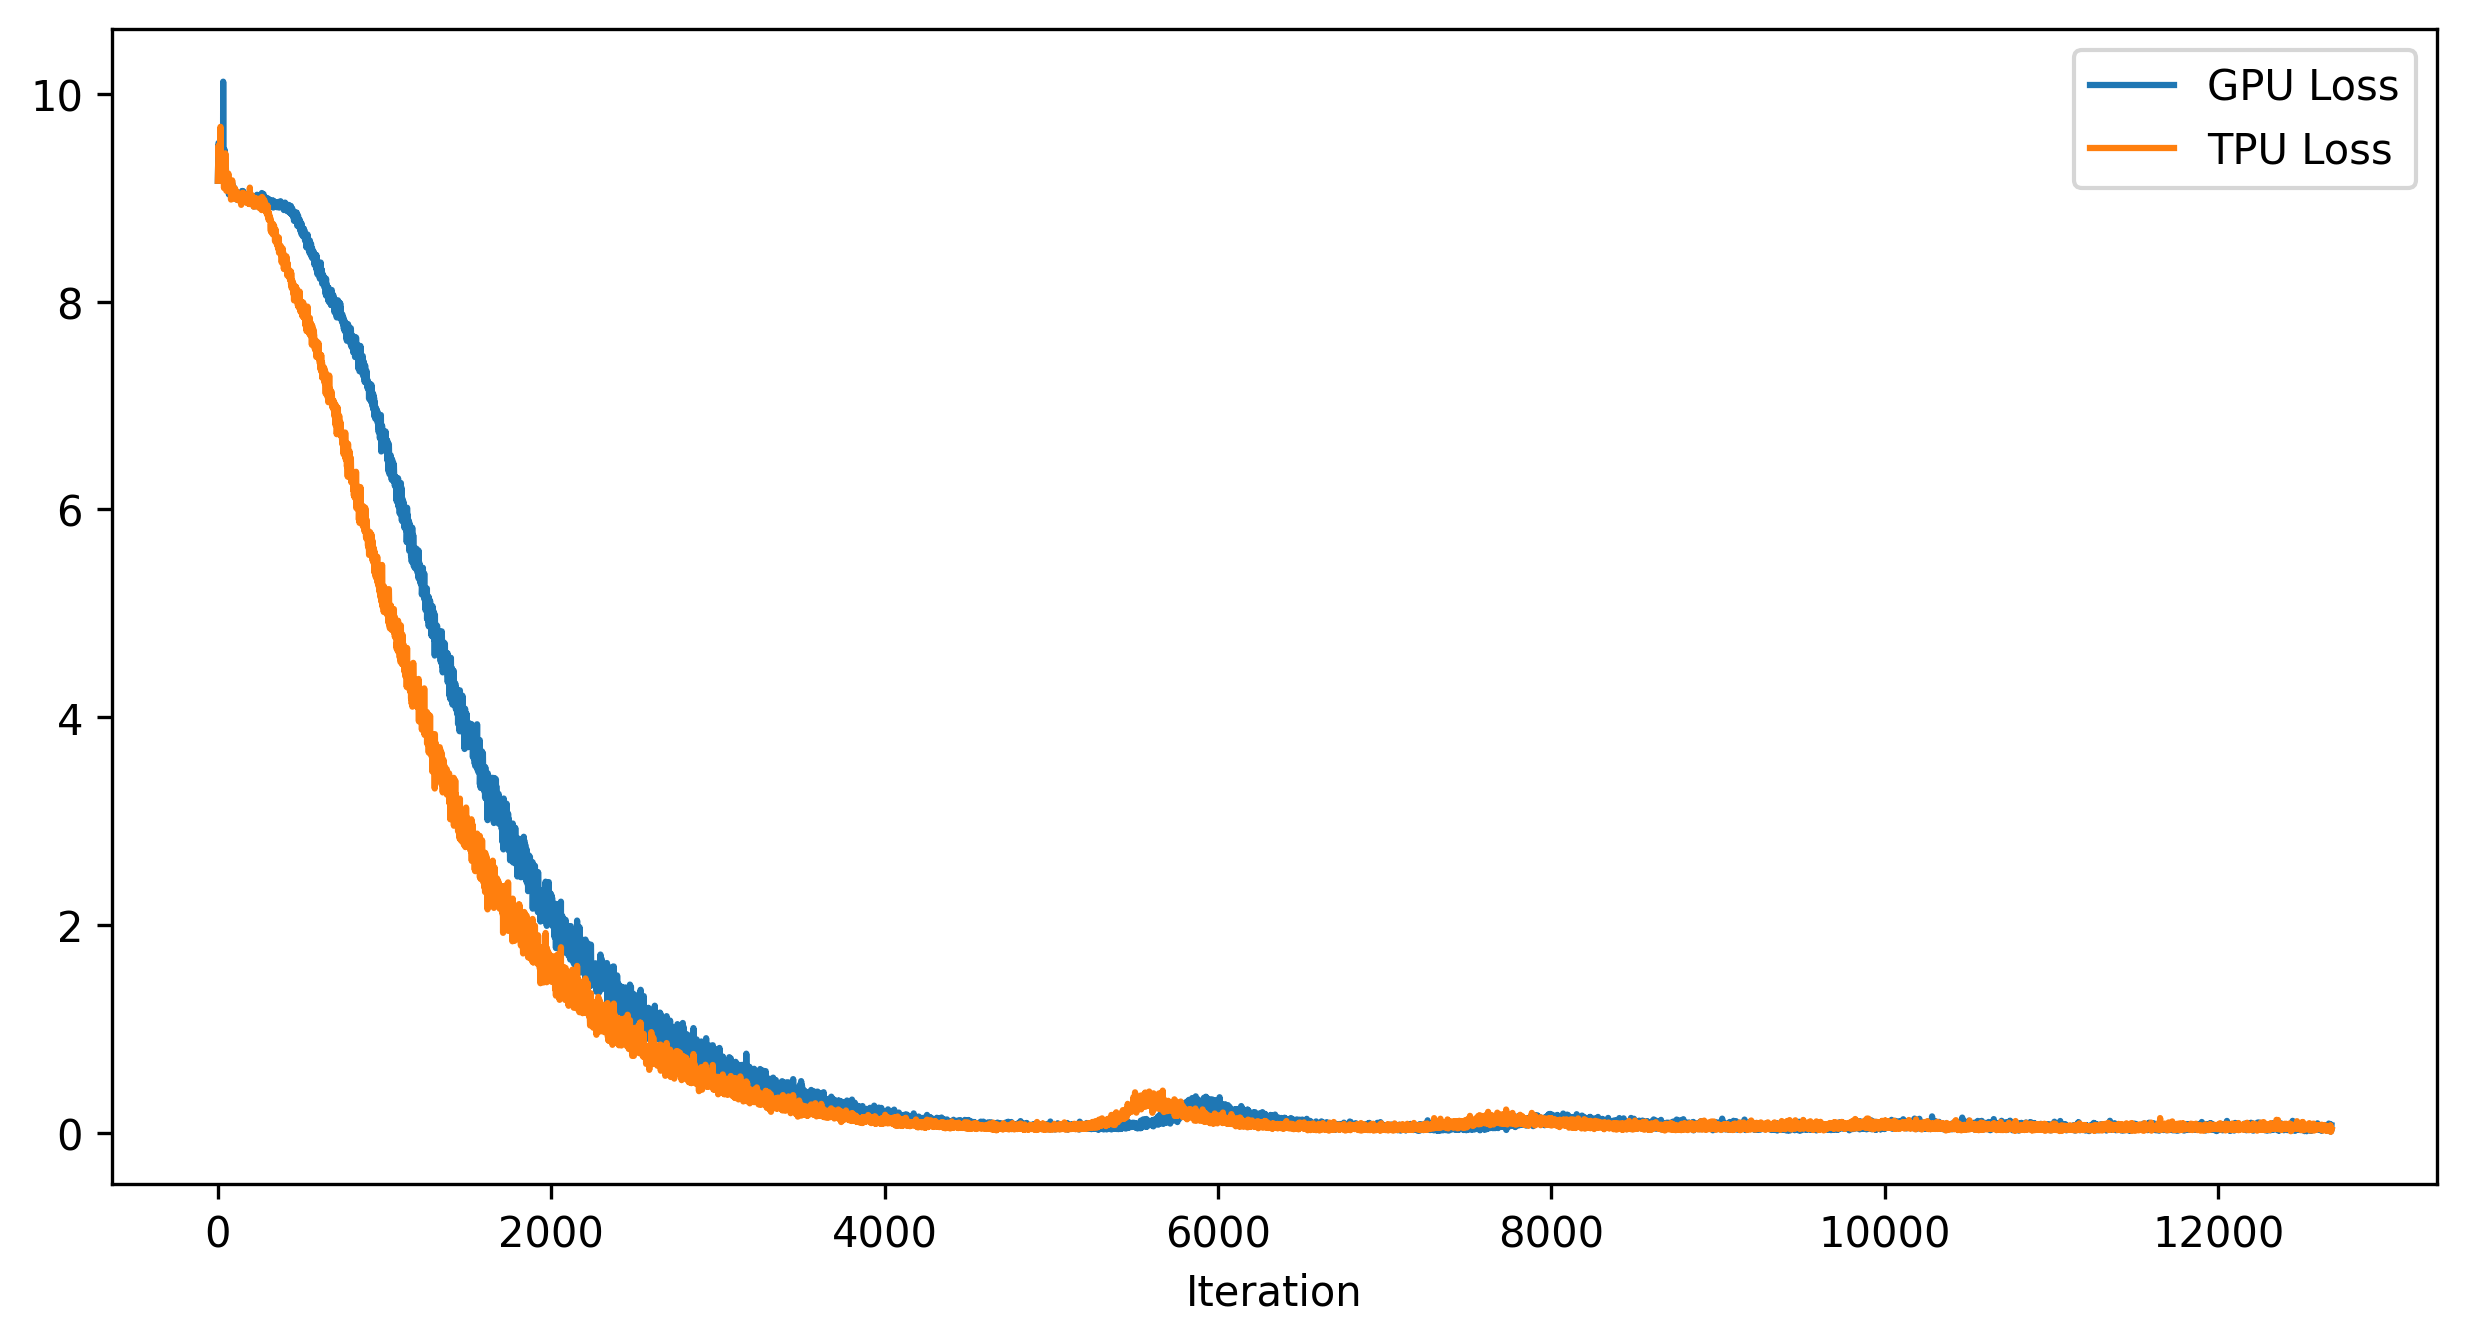

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(gpu_losses, label='GPU Loss')
plt.plot(tpu_losses, label='TPU Loss')
plt.xlabel('Iteration') 
plt.legend()
plt.show()

In [ ]:
import os
import json

# Save the gpu and tpu losses to `outputs/` in JSON format.
os.makedirs("outputs/convergence/lr-1e-3", exist_ok=True)

with open("outputs/convergence/lr-1e-3/gpu_losses.json", "w") as f:
  json.dump(gpu_losses, f)

with open("outputs/convergence/lr-1e-3/tpu_losses.json", "w") as f:
  json.dump(tpu_losses, f)

with open("outputs/convergence/lr-1e-3/gpu_validation_metrics.json", "w") as f:
  json.dump(gpu_validation_metrics, f)

with open("outputs/convergence/lr-1e-3/tpu_validation_metrics.json", "w") as f:
  json.dump(tpu_validation_metrics, f)